### Train Model Experiments NB 
This notebook contains the code to split the images and load them into train and validate sets.  The notebook also has the definition for the way the data should be loaded for each of six computer vision model types.  The notebook uses the concept of experiments to organize the fit/validate activities and allow for hyperparameter searching and logging results.  

Scroll down to the head "Experiments" and add your experiment as a new cell underneath the heading, modify the experiment meta data and run the cell.  



In [1]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS
from tensorflow.keras.callbacks import ModelCheckpoint


# add capabilities to generate data and stop early as well as regulation options to avoid over fitting per experiment #1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import all model architectures
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.applications import InceptionV3


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
import math

# suppress warnings
from absl import logging  # tensorflow internal log
logging.set_verbosity(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)


2025-03-23 14:35:55.109198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-23 14:35:56.102726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-03-23 14:35:56.102837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [2]:
# define a dictionary for model config and experiment tracking.... 
# define global variables
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)

model_input_variables = {'MobileNetV2': {'input_shape': (224, 224, 3), 'batch_size': 32,},
     'MobileNetV3Large': {'input_shape': (224, 224, 3),'batch_size': 32,},
    'MobileNetV3Small':{'input_shape': (224, 224, 3), 'batch_size': 32,},
    'EfficientNetB0': {'input_shape': (224, 224, 3), 'batch_size': 32,},
    'InceptionV3': {'input_shape': (299, 299, 3), 'batch_size': 32,}, # InceptionV3 typically uses 299x299
    'EfficientNetB7':{'input_shape': (600, 600, 3), 'batch_size': 16,} # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
}
models_list = list(model_input_variables.keys())

In [3]:
def write_results_to_file(filename, experiment, start_time, end_time, model_name, epochs, 
                          training_accuracy, validate_accuracy, training_loss, validate_loss,
                          num_stages, stage1, stage2):
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    batch_size = str(model_input_variables[model_name]['batch_size'])
    input_shape = str(model_input_variables[model_name]['input_shape']).replace(',','x')
    stage1 = f"stage1 epochs:{stage1['epochs']} trainable: {stage1['base_trainable']} trainable layers: {stage1['trainable_layers']} learning rate: {stage1['learning_rate']}"
    stage2 = f"stage2 epochs:{stage2['epochs']} trainable: {stage2['base_trainable']} trainable layers: {stage2['trainable_layers']} learning rate: {stage2['learning_rate']}"
    line = f'{experiment},{start_time_str},{end_time_str},{model_name},{batch_size},{epochs},{input_shape},{training_accuracy},' \
           f'{validate_accuracy},{training_loss},{validate_loss},{num_stages},{stage1},{stage2}\n'
    if not os.path.exists(filename):      # Check if the file exists, and add a header if it's new
        header = 'experiment,start_time,end_time,model_name,batch_size,epochs,input_shape,training_accuracy,validate_accuracy,training_loss,validate_loss,num_stages,stage1,stage2\n'
        with open(filename, "w") as f:
            f.write(header + line)
    else:
        with open(filename, "a") as f: # append to existing file
            f.write(line)
    print(f'experiment tracking updated')
    return

In [4]:
def load_images_gcs(bucket_name, dataset_path, model_image_size, model_batch_size):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=model_image_size,
            batch_size=model_batch_size, label_mode='categorical',)  # categorical is for softmax layer
    except Exception as e:
        print(f'error loading dataset from gcs: {e}')    
    return dataset

In [5]:
# split into its own cell so we do not have to repeat this long operation, takes 10 minutes....
# need to run this each time for different image and batch sizes
def load_images(image_size=default_image_size, batch_size=default_batch_size):
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start loading images time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'Loading with image size of {image_size} and batch size of {batch_size}')

    train_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'train'), image_size, batch_size)
    validate_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'test'), image_size, batch_size)

    if train_dataset is None or validate_dataset is None:
        print(f'dataset loading failed.')
    return train_dataset, validate_dataset

In [6]:
def plot_training_results(acc, validate_acc, loss, validate_loss):
    epochs_plt = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
    plt.plot(epochs_plt, validate_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_plt, loss, 'b', label='Training loss')
    plt.plot(epochs_plt, validate_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [7]:
# lock and unlock layers, make this bullet proof so I don't have to think about the experiments too much
def lock_unlock_layers(model, train_last_x_layers):
    train_last_x_layers = 0 if train_last_x_layers == None else train_last_x_layers
    fine_tune_at = len(model.layers) - abs(train_last_x_layers)                        
    fine_tune_at = 0 if fine_tune_at < 0 else fine_tune_at
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True
    return model

In [17]:
def run_model_experiment(experiment_name, model_name, stages, stage1, stage2, train_dataset, validate_dataset, num_classes, log_record):
    stage1_learning = stage1["learning_rate"]
    stage1_epochs = stage1["epochs"]
    stage1_base_trainable = stage1['base_trainable']
    stage1_trainable_layers = stage1['trainable_layers']
    stage2_learning = stage2["learning_rate"]
    stage2_epochs = stage2["epochs"]
    stage2_base_trainable = stage2['base_trainable']
    stage2_trainable_layers = stage2['trainable_layers']
    
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'building model: {model_name} with {stages} stage(s)')
    print(f'stage1... ')
    print(f'epochs: {stage1_epochs}')
    print(f'learning rate of {stage1_learning}')
    print(f'trainable: {stage1_base_trainable}')
    print(f'trainable_layers: {stage1_trainable_layers}')
    
     # load each mode type and modify head for softmax replacement
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        print(f'unknown model {model_name} inf run_model_experiment case statement')

    ### setup call backs and other admin...
    # save best model, save model when monitored metric improved, 'max' for accuracy, 'min' for loss
    # callbacks early stopping and learning rate reduction
    # suppress warnings
    model_filename = experiment_name + model_name
    # model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)  # added save weights for efficientnet
    model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    #####  setup stage 1 of X #####
    base_model.trainable = stage1_base_trainable  # true unlocks the entire model
    if stage1_base_trainable is False and stage1_trainable_layers != None:  # false a number unlocks the last x layers
        base_model = lock_unlock_layers(model=base_model, train_last_x_layers=stage1_trainable_layers)
    x = base_model.output  # start adding custom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  
    predictions = Dense(num_classes, activation='softmax')(x)

    # create the model with rescaling layer, this will automatically normalize the images within the model, bulletproofs feeder code
    # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
    inputs = base_model.input
    rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  
    x = base_model(rescaled_inputs) # pass rescaled input through the base model
    model = Model(inputs=inputs, outputs=predictions) # use original inputs, this is weird, but how it was done in tutorial...

    # compile and train model, epoch zero is starting place for first stage, categorical crossentropy is for multi-class classification
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage1_learning), loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history_phase1 = model.fit(train_dataset, epochs=stage1_epochs, initial_epoch=0, validation_data=validate_dataset, 
                               callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] )  

    ##### setup stage 2 if requested
    combined_history = {}
    print(f'history 1 keys: {history_phase1.history.keys()}')
    if stages == 2:
        print(f'stage2...')
        model = lock_unlock_layers(model=model, train_last_x_layers=stage2_trainable_layers)
        # Recompile the model and continue from phase1, last epoch + 1 to move to next available 
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage2_learning), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_phase2 = model.fit(train_dataset, epochs=stage1_epochs + stage2_epochs, initial_epoch=stage1_epochs, validation_data=validate_dataset,
                                  callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])   
        print(f'history2 keys: {history_phase2.history.keys()}')
        for key in history_phase1.history:  # combine history
            try:
                combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
            except:
                pass
                #     print(f'history1 key {key} not found in history2 ')
        for key2 in history_phase2.history:
            if key2 not in history_phase1.history:
                combined_history[key2] = history_phase2.history[key2]
    else:
        stage2_epochs=0
        combined_history = history_phase1.history  # if one state take stage 1 hist    
                
    #### process results and save model
    # Load the best weights saved by the ModelCheckpoint callback, save the entire model (architecture + weights)
    try:
        model.load_weights(model_filename)
        keras.models.save_model(model, model_filename)
        print(f'Full model with best weights saved to: {model_filename}')
    except Exception as e:
        print(f'model save failed with error {e}')
    
    # record training time
    end_time = time.time()
    end_time_datetime = datetime.datetime.fromtimestamp(end_time)
    print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

    # write_results_to_file
    total_epochs = stage1_epochs + stage2_epochs
    acc = combined_history['accuracy']
    validate_acc = combined_history['val_accuracy']
    loss = combined_history['loss']
    validate_loss = combined_history['val_loss']

    if log_record:
        write_results_to_file('experiment_log.csv', experiment_name, start_time_datetime, end_time_datetime, model_name, total_epochs, 
                              acc[-1], validate_acc[-1], loss[-1], validate_loss[-1], stages, stage1, stage2)
    plot_training_results(acc, validate_acc, loss, validate_loss) 
    return acc, validate_acc, loss, validate_loss

In [9]:
# the experiments dictionary drives the model types and training parameters 
# loop over each model type, stages, and write out results of experiment to a file, save the model
def run_experiments(experiments, train_dataset, validate_dataset, num_classes, log_record=True):
    for exper in list(experiments.keys()):
        stages = experiments[exper]['number_of_stages']
        stage1 = experiments[exper]['stage1']
        stage2 = experiments[exper]['stage2']
        
        for model_num in experiments[exper]['model_types']:
            model_name = models_list[model_num]
            acc, validate_acc, loss, validate_loss = run_model_experiment(exper, model_name, stages, stage1, stage2, 
                                                                          train_dataset, validate_dataset, num_classes, 
                                                                         log_record)
    return

In [10]:
# load the default data 224x224x3 ,batch size 32 data set.  do not loop over this code unless its an exception. 
# takes about 10 minutes, note this will output warning/errors since this NB is not using a GPU
# request a different load for a different model size, copy and paste code and change parameters
default_train_dataset, default_validate_dataset = load_images()
num_classes = len(default_train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-03-23 14:36:01
Loading with image size of (224, 224) and batch size of 32
Found 2455 files belonging to 27 classes.


2025-03-23 14:40:46.213035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-23 14:40:46.578738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-23 14:40:46.582281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-23 14:40:46.589263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f71a171d1b0> (key: FunctionCacheKey(function_type=FunctionType(parameters=[Parameter(name=args_kwargs, kindPOSITIONAL_ONLY, optional=False, type_constraint=Tuple(components=(Tuple(components=(TensorSpec(shape=(), dtype=tf.string, name=None),)), Dict(mapping={}))))], captures=OrderedDict()), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: (TensorSpec(shape=(), dtype=tf.string, name=None),)] [kwargs: {}]
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f71a171eb00> (key: FunctionCacheKey(function_type=FunctionType(parameters=[Parameter

### Experiments
quick primer:  
Accuracy: overall proportion of correct predictions (both true positives and true negatives) out of all predictions made.
Formula: (True Positives + True Negatives) / (Total Predictions)
Precision: measures the proportion of true positive predictions out of all positive predictions made by the model.
Formula: True Positives / (True Positives + False Positives)
Recall (also known as Sensitivity): measures the proportion of actual positive instances that the model correctly identified.
Formula: True Positives / (True Positives + False Negatives)

- Early experiment: learning_rate to low resulted in overfitting .001 with 50 epochs.  Added code to save best model since the results detoritated as more epochs were applied.  added libraries to generate more images if needed and for early stopping and learning rate reduction.  not in code yet 
- Experiment1: lowered learning rate to .0001 and trained for 25 epochs.  much better result.
- Experiment2: incorporated early stopping code and learning rate reduction and increased epochs to 50.  future: add regulaziation and drop out layers? add more training images?

In [ ]:
### Available Models
print(f'Available models: {models_list}')
print(f'EfficientNetB0: {model_input_variables["EfficientNetB0"]}')
print(f'MobileNetV2: {model_input_variables["MobileNetV2"]}')
print(f'MobileNetV3Large: {model_input_variables["MobileNetV3Large"]}')
print(f'MobileNetV3Small: {model_input_variables["MobileNetV3Small"]}')
print(f'InceptionV3: {model_input_variables["InceptionV3"]}')
print(f'EfficientNetB7: {model_input_variables["EfficientNetB7"]}')

Available models: ['MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'EfficientNetB0', 'InceptionV3', 'EfficientNetB7']
EfficientNetB0: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV2: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Large: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Small: {'input_shape': (224, 224, 3), 'batch_size': 32}
InceptionV3: {'input_shape': (299, 299, 3), 'batch_size': 32}
EfficientNetB7: {'input_shape': (600, 600, 3), 'batch_size': 16}


### Recorded Experiments


In [24]:
# #### Test 1, MobileNetV2 2 Epochs, No logging, No save model, testing only
# models_list = list(model_input_variables.keys())
# base_experiments_dict = {
#     'Experiment1: MobileNetV2 50 Epochs': { 
#         # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
#         'model_types': [0], # mobilenetv2 only
#         'number_of_stages': 1, 
#         'stage1': {'epochs': 2, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.001},
#         'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}  
#            # 'stage2': {'epochs': 2, 'trainable': True, 'trainable_layers': -2, 'learning_rate': 0.00001}
#     }
# }

# run_experiments(base_experiments_dict, default_train_dataset, default_validate_dataset, num_classes, log_record=False)

Start time training and validation: 2025-03-23 17:17:51
building model: EfficientNetB0 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50


2025-03-23 17:18:07.551367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - ETA: 0s - loss: 2.6911 - accuracy: 0.3556 - precision_4: 0.9730 - recall_4: 0.0147
Epoch 1: val_accuracy improved from -inf to 0.69404, saving model to Experiment2: EfficientNetB0 1 stage 50 EpochsEfficientNetB0
77/77 [==============================] - 96s 752ms/step - loss: 2.6911 - accuracy: 0.3556 - precision_4: 0.9730 - recall_4: 0.0147 - val_loss: 1.0931 - val_accuracy: 0.6940 - val_precision_4: 0.9078 - val_recall_4: 0.4122 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.8187 - precision_4: 0.9718 - recall_4: 0.5185
Epoch 2: val_accuracy improved from 0.69404 to 0.87923, saving model to Experiment2: EfficientNetB0 1 stage 50 EpochsEfficientNetB0
77/77 [==============================] - 61s 718ms/step - loss: 0.9091 - accuracy: 0.8187 - precision_4: 0.9718 - recall_4: 0.5185 - val_loss: 0.4121 - val_accuracy: 0.8792 - val_precision_4: 0.9357 - val_recall_4: 0.8438 - lr: 1.0000e-04
Ep

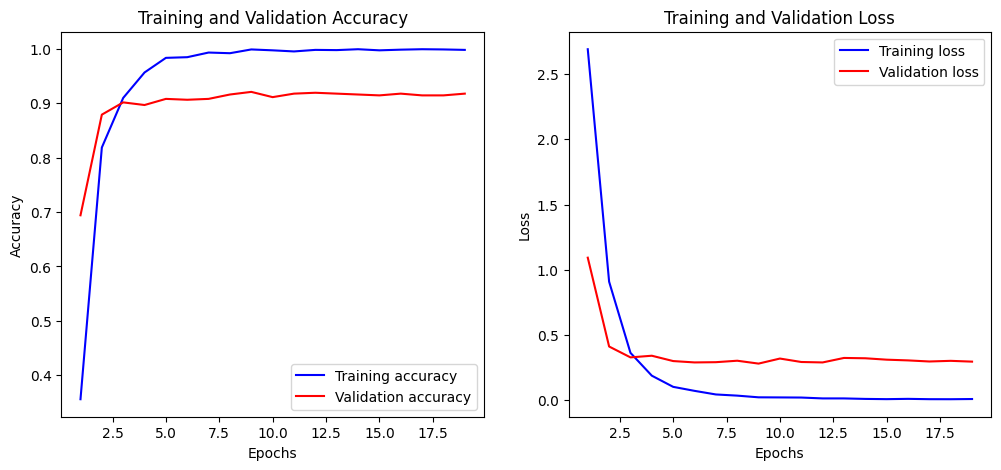

In [18]:
#### Experiment 2 EfficentNetB0 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment2: EfficientNetB0 1 stage 50 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [3], # efficientnetB0
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-23 16:39:04
building model: MobileNetV3Small with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 2.8340 - accuracy: 0.2261 - precision_2: 1.0000 - recall_2: 0.0073
Epoch 1: val_accuracy improved from -inf to 0.38969, saving model to Experiment2: MobileNet V3Small 1 stage 50 EpochsMobileNetV3Small
77/77 [==============================] - 83s 732ms/step - loss: 2.8340 - accuracy: 0.2261 - precision_2: 1.0000 - recall_2: 0.0073 - val_loss: 1.9607 - val_accuracy: 0.3897 - val_precision_2: 0.7634 - val_recall_2: 0.1143 - lr: 1.0000e-04
Epoch 2/50
76/77 [============================>.] - ETA: 0s - loss: 1.3996 - accuracy: 0.6365 - precision_2: 0.9380 - recall_2: 0.2738
Epoch 2: val_accuracy improved from 0.38969 to 0.60548, saving model to Experiment2: MobileNet V3Small 1 stage 50 EpochsMobileNetV3Small
77/77 [=======================

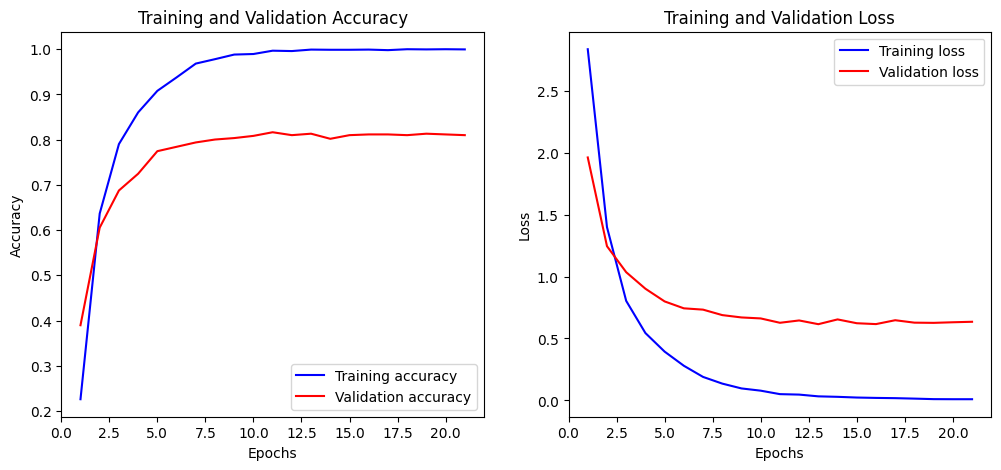

In [14]:
#### Experiment 2 MobileNetV3 Small 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment2: MobileNet V3Small 1 stage 50 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [2], # mobilenetv3Small
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-23 15:12:50
building model: MobileNetV3Large with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 2.4815 - accuracy: 0.3483 - precision_1: 0.9653 - recall_1: 0.0566
Epoch 1: val_accuracy improved from -inf to 0.58132, saving model to Experiment2: MobileNet V3Large V3Small 1 stage 50 EpochsMobileNetV3Large
77/77 [==============================] - 95s 809ms/step - loss: 2.4815 - accuracy: 0.3483 - precision_1: 0.9653 - recall_1: 0.0566 - val_loss: 1.3538 - val_accuracy: 0.5813 - val_precision_1: 0.8185 - val_recall_1: 0.3414 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.8269 - precision_1: 0.9477 - recall_1: 0.6428
Epoch 2: val_accuracy improved from 0.58132 to 0.71176, saving model to Experiment2: MobileNet V3Large V3Small 1 stage 50 EpochsMobileNetV3Large
77/77 [=======

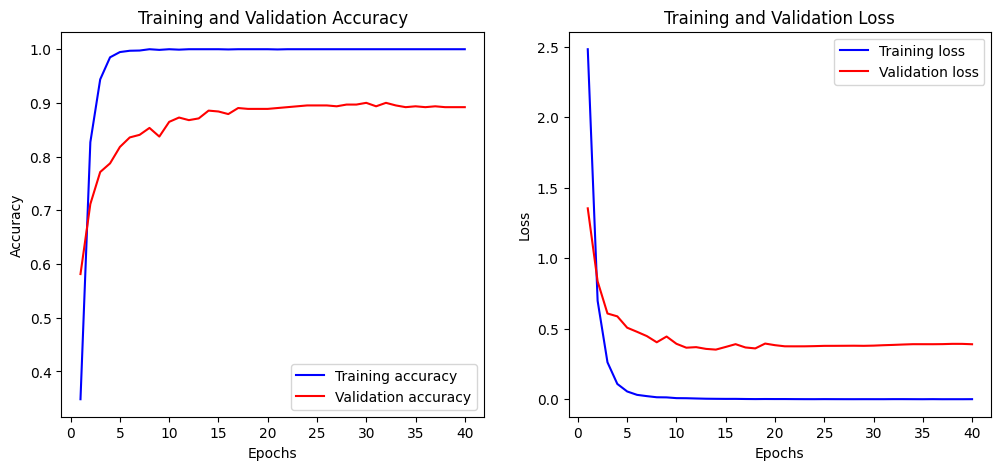

In [13]:
#### Experiment 2 MobileNetV3 large 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment2: MobileNet V3Large 1 stage 50 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [1], # mobilenetv3large
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-23 14:41:58
building model: MobileNetV2 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50


2025-03-23 14:42:15.799697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2025-03-23 14:42:17.147068: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55945ebbf380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-23 14:42:17.147109: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-23 14:42:17.196173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-23 14:42:17.611955: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 [==============================] - ETA: 0s - loss: 1.9411 - accuracy: 0.4961 - precision: 0.9391 - recall: 0.1886
Epoch 1: val_accuracy improved from -inf to 0.23510, saving model to Experiment2: MobileNetV2 1 stage 50 Epochs early stopping and automatic learning rate reductionMobileNetV2
77/77 [==============================] - 96s 835ms/step - loss: 1.9411 - accuracy: 0.4961 - precision: 0.9391 - recall: 0.1886 - val_loss: 2.7516 - val_accuracy: 0.2351 - val_precision: 0.5965 - val_recall: 0.0548 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8941 - precision: 0.9574 - recall: 0.7967
Epoch 2: val_accuracy improved from 0.23510 to 0.37198, saving model to Experiment2: MobileNetV2 1 stage 50 Epochs early stopping and automatic learning rate reductionMobileNetV2
77/77 [==============================] - 63s 768ms/step - loss: 0.4504 - accuracy: 0.8941 - precision: 0.9574 - recall: 0.7967 - val_loss: 2.1496 - val_accuracy: 0

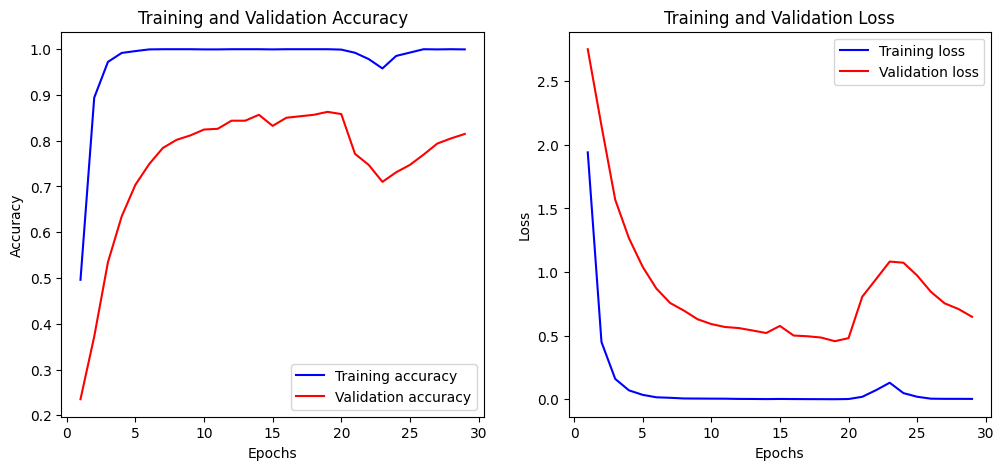

In [ ]:
#### Experiment 2, MobileNetV2 50 Epochs
# added code to stop early and reduce learning rate automatically 
models_list = list(model_input_variables.keys())
experiments_dict = {
    'Experiment2: MobileNetV2 1 stage 50 Epochs early stopping and automatic learning rate reduction': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # mobilenetv2 only
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}  
    }
}

run_experiments(experiments_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-03-22 16:51:34
building model: MobileNetV2 with 1 stage(s)
stage1... 
epochs: 25
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/25
77/77 [==============================] - ETA: 0s - loss: 1.9875 - accuracy: 0.4729 - precision_5: 0.9408 - recall_5: 0.1813
Epoch 1: val_accuracy improved from -inf to 0.21578, saving model to model_checkpoint.h5
77/77 [==============================] - 96s 854ms/step - loss: 1.9875 - accuracy: 0.4729 - precision_5: 0.9408 - recall_5: 0.1813 - val_loss: 2.6886 - val_accuracy: 0.2158 - val_precision_5: 0.6786 - val_recall_5: 0.0612
Epoch 2/25
77/77 [==============================] - ETA: 0s - loss: 0.4373 - accuracy: 0.8998 - precision_5: 0.9567 - recall_5: 0.8012
Epoch 2: val_accuracy improved from 0.21578 to 0.39614, saving model to model_checkpoint.h5
77/77 [==============================] - 72s 857ms/step - loss: 0.4373 - accuracy: 0.8998 - precision_5: 0.9567 - recall_5: 0.8012 - val_loss:

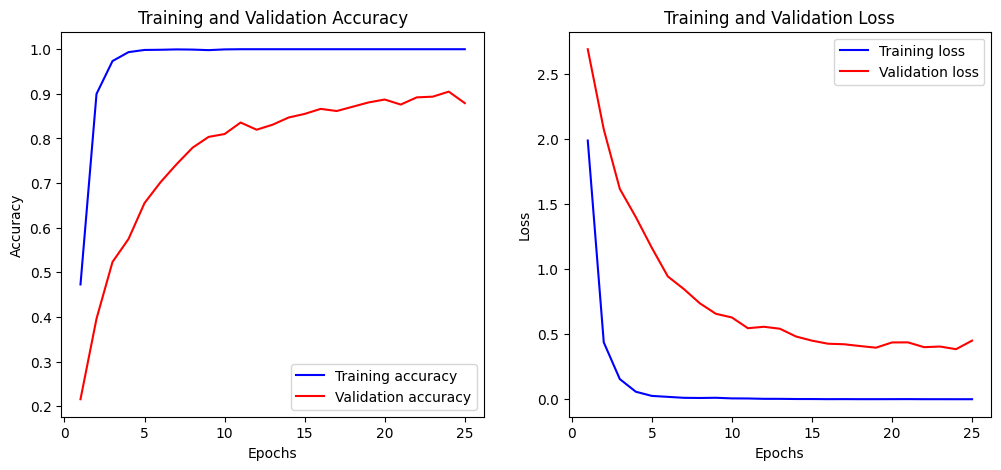

In [25]:
#### Experiment 1, MobileNetV2 25 Epochs
# notes: display overfitting with 80 training images very early.  
# added code to save best model (callback)
# need to add code to create additional training data (augmentation) to avoid overfitting
# decreased learning rate to avoid overfitting as well from .001 to .0001
models_list = list(model_input_variables.keys())
base_experiments_dict = {
    'Experiment1: MobileNetV2 1 stage 25 Epochs': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # mobilenetv2 only
        'number_of_stages': 1, 
        'stage1': {'epochs': 25, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 0, 'base_trainable': None, 'trainable_layers': None, 'learning_rate': 0}  
    }
}

run_experiments(base_experiments_dict, default_train_dataset, default_validate_dataset, num_classes, log_record=True, save_model=False)